In [1]:
import torch
import os, sys
import numpy as np
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
hr_audio_path = '/home/neoncloud/pix2pixHDAudioSR/checkpoints/gen_vctk_hifitts_G4A3L3_56ngf_3x/hr_audio.wav'
sr_audio_path = '/home/neoncloud/pix2pixHDAudioSR/checkpoints/gen_vctk_hifitts_G4A3L3_56ngf_3x/sr_audio.wav'
hr_metadata = torchaudio.info(hr_audio_path)
print(hr_metadata.num_frames)
sr_metadata = torchaudio.info(sr_audio_path)
print(sr_metadata.num_frames)
hr_audio, fs = torchaudio.load(hr_audio_path)
sr_audio, fs = torchaudio.load(sr_audio_path)
#sr_audio = sr_audio[...,5000:]

374855
390144


tensor(-2.2878e-06)


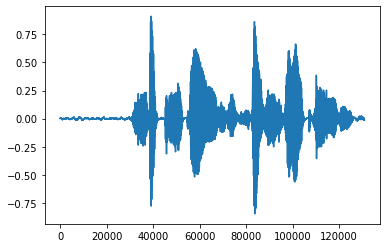

In [3]:
K = 20000
hr_audio_ = hr_audio[...,K:130816+K].squeeze()
print(hr_audio.mean())
plt.plot(hr_audio_)
plt.show()

tensor(0.0004)


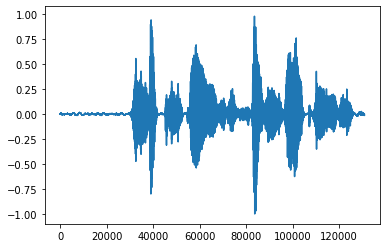

In [4]:
sr_audio_ = sr_audio[...,K:130816+K].squeeze()
print(sr_audio.mean())
plt.plot(sr_audio_)
plt.show()

tensor(167841)


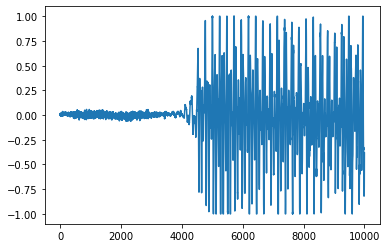

In [5]:
from torch.nn.functional import conv1d
win_len = 10000
sr_idx = torch.argmax(sr_audio.pow(2))
print(sr_idx)
sr_sample = sr_audio.squeeze()[None, None, int(sr_idx-win_len//2):int(sr_idx+win_len//2)]
plt.plot(sr_sample.squeeze())
plt.show()

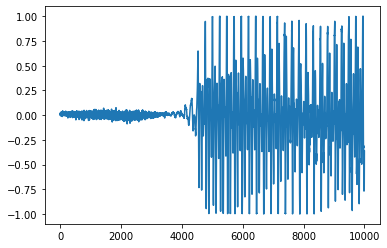

In [6]:
hr_sample = hr_audio.squeeze()[None, None, int(sr_idx-win_len//2):int(sr_idx+win_len//2)]
plt.plot(hr_sample.squeeze())
plt.show()

torch.Size([364856])
tensor(162841)


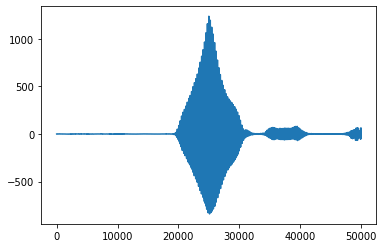

In [26]:
corr = conv1d(hr_audio[None,...],sr_sample).squeeze()
print(corr.shape)
corr_max = torch.argmax(corr)
print(corr_max)
plt.plot(corr[corr_max-25000:corr_max+25000])
plt.show()

In [8]:
diff = corr_max-sr_idx+win_len//2
print(diff)

tensor(0)


In [9]:
if diff<0:
    sr_audio = sr_audio[...,-diff:]
else:
    sr_audio = torch.nn.functional.pad(sr_audio,(diff,0))
print(sr_audio.shape, hr_audio.shape)
trim = sr_audio.size(-1)-hr_audio.size(-1)
print(trim)
if trim>0:
    sr_audio = sr_audio[...,:-trim]
else:
    sr_audio = torch.nn.functional.pad(sr_audio,(0,-trim))
print(sr_audio.shape, hr_audio.shape)

torch.Size([1, 390144]) torch.Size([1, 374855])
15289
torch.Size([1, 374855]) torch.Size([1, 374855])


tensor(0.0011)


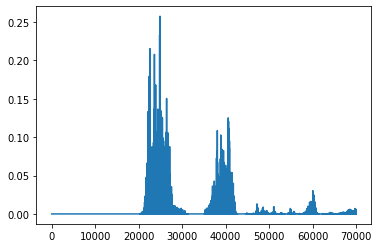

In [10]:
diff_ = (hr_audio-sr_audio).squeeze()**2
print(diff_.mean())
plt.plot(diff_[30000:100000])
plt.show()

In [25]:
hr_stft = aF.spectrogram(hr_audio, n_fft=400, hop_length=200, win_length=400, window=torch.hann_window(400), center=True, pad=0, power=1, normalized=False)
sr_stft = aF.spectrogram(sr_audio, n_fft=400, hop_length=200, win_length=400, window=torch.hann_window(400), center=True, pad=0, power=1, normalized=False)
lsd = hr_stft.pow(2).add(1e-9).log10()-sr_stft.pow(2).add(1e-9).log10()
lsd = lsd.pow(2).mean(1).sqrt().mean(-1)
print(lsd)

tensor([0.8914])
